In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis

Checking R installation...
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.19'
is available with R version '4.4'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis
Attaching package: ‘devtools’
The 

In [2]:
pg = pp.read_csv("../txt/proteinGroups.txt")
pg = pp.cleaning(pg)

pg_raw = pg.copy()
print(f"Identified a total of {pg.shape[0]} protein groups")

1453 rows before filter operation.
1287 rows after filter operation.
Identified a total of 1287 protein groups


In [3]:
pg["Gene names first"] = pg["Gene names"].str.split(";").str[0]

In [4]:
# replace 0 by np nan before vsn normalisatoin
ibaq = pg.filter(regex="^iBAQ [C|T|Z|S|D]").columns.tolist()
pg[ibaq] = pg[ibaq].replace(0, np.nan)

In [5]:
# loading correction
low_injection = [x for x in ibaq if ("ZNF703_" in x) and x.endswith("_3")]
pg[low_injection] *= 14 / 7.5  # 7.5 uL injected vs. 14 uL in the rest

print("Correction of loading for: " + ", ".join(low_injection))

Correction of loading for: iBAQ ZNF703_Rep1_3, iBAQ ZNF703_Rep2_3, iBAQ ZNF703_Rep3_3


In [6]:
for exp in ["Ctrl", "DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    for rep in range(1, 4):
        sub_df = pg.filter(regex=f"iBAQ {exp}_Rep{rep}.*")
        print("Summing: " + ", ".join(sub_df.columns.tolist()))
        # sum all slices per replicate
        pg[f"sum_intens_{exp}_Rep{rep}"] = sub_df.dropna(how="all").apply(
            np.nansum, axis=1
        )

Summing: iBAQ Ctrl_Rep1_3, iBAQ Ctrl_Rep1_5, iBAQ Ctrl_Rep1_Pool
Summing: iBAQ Ctrl_Rep2_3, iBAQ Ctrl_Rep2_5, iBAQ Ctrl_Rep2_Pool
Summing: iBAQ Ctrl_Rep3_3, iBAQ Ctrl_Rep3_5, iBAQ Ctrl_Rep3_Pool
Summing: iBAQ DUSP11_Rep1_3, iBAQ DUSP11_Rep1_5, iBAQ DUSP11_Rep1_Pool
Summing: iBAQ DUSP11_Rep2_3, iBAQ DUSP11_Rep2_5, iBAQ DUSP11_Rep2_Pool
Summing: iBAQ DUSP11_Rep3_3, iBAQ DUSP11_Rep3_5, iBAQ DUSP11_Rep3_Pool
Summing: iBAQ SMIM26_Rep1_3, iBAQ SMIM26_Rep1_5, iBAQ SMIM26_Rep1_Pool
Summing: iBAQ SMIM26_Rep2_3, iBAQ SMIM26_Rep2_5, iBAQ SMIM26_Rep2_Pool
Summing: iBAQ SMIM26_Rep3_3, iBAQ SMIM26_Rep3_5, iBAQ SMIM26_Rep3_Pool
Summing: iBAQ TMEM186_Rep1_3, iBAQ TMEM186_Rep1_5, iBAQ TMEM186_Rep1_Pool
Summing: iBAQ TMEM186_Rep2_3, iBAQ TMEM186_Rep2_5, iBAQ TMEM186_Rep2_Pool
Summing: iBAQ TMEM186_Rep3_3, iBAQ TMEM186_Rep3_5, iBAQ TMEM186_Rep3_Pool
Summing: iBAQ ZNF703_Rep1_3, iBAQ ZNF703_Rep1_5, iBAQ ZNF703_Rep1_Pool
Summing: iBAQ ZNF703_Rep2_3, iBAQ ZNF703_Rep2_5, iBAQ ZNF703_Rep2_Pool
Summing: iBAQ Z

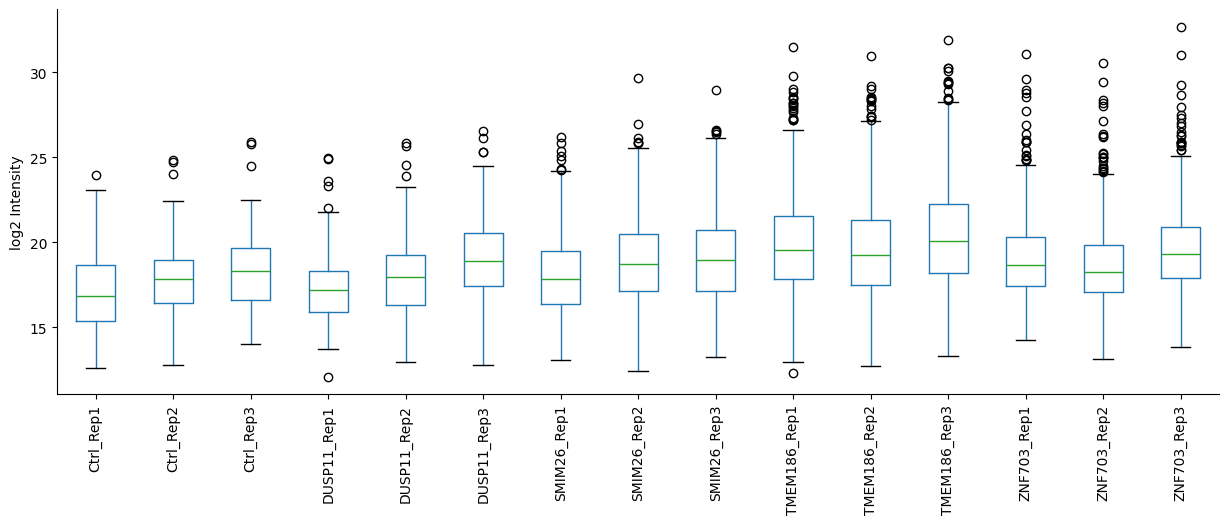

In [7]:
tmp, log_cols = pp.log(
    pg, pg.filter(regex=f"sum_intens_").columns.tolist(), return_cols=True
)

vis.boxplot(
    tmp,
    log_cols,
    labels=[x[16:] for x in log_cols],
)
plt.xticks(rotation=90)
plt.ylabel("log2 Intensity")
plt.show()

In [8]:
# per experiment vsn
for exp in ["Ctrl", "DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    group = pg.filter(regex=f"sum_intens_{exp}").columns
    print("Normalizing group: " + ", ".join(group))
    pg = pp.vsn(pg, group, print_r=False)

Normalizing group: sum_intens_Ctrl_Rep1, sum_intens_Ctrl_Rep2, sum_intens_Ctrl_Rep3
Normalizing group: sum_intens_DUSP11_Rep1, sum_intens_DUSP11_Rep2, sum_intens_DUSP11_Rep3
Normalizing group: sum_intens_SMIM26_Rep1, sum_intens_SMIM26_Rep2, sum_intens_SMIM26_Rep3
Normalizing group: sum_intens_TMEM186_Rep1, sum_intens_TMEM186_Rep2, sum_intens_TMEM186_Rep3
Normalizing group: sum_intens_ZNF703_Rep1, sum_intens_ZNF703_Rep2, sum_intens_ZNF703_Rep3


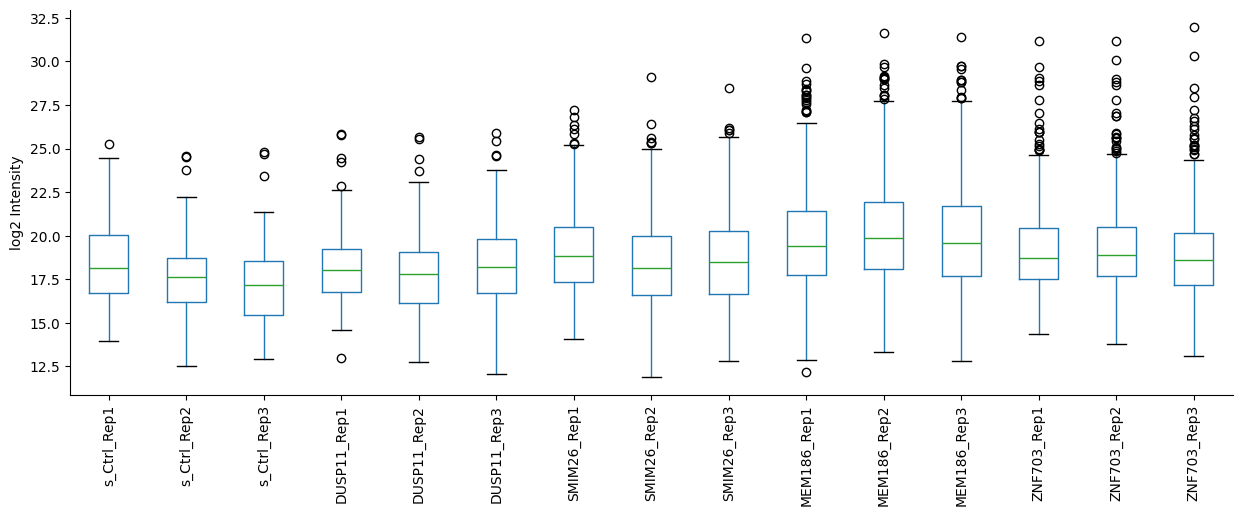

In [9]:
vsn_norm_cols = pg.filter(regex="normalized").columns.tolist()

vis.boxplot(
    pg,
    vsn_norm_cols,
    labels=[x[-22:-11] for x in vsn_norm_cols],
)
plt.xticks(rotation=90)
plt.ylabel("log2 Intensity")
plt.savefig(f"PR100_box_vsn_3reps.pdf", dpi=300)
plt.show()

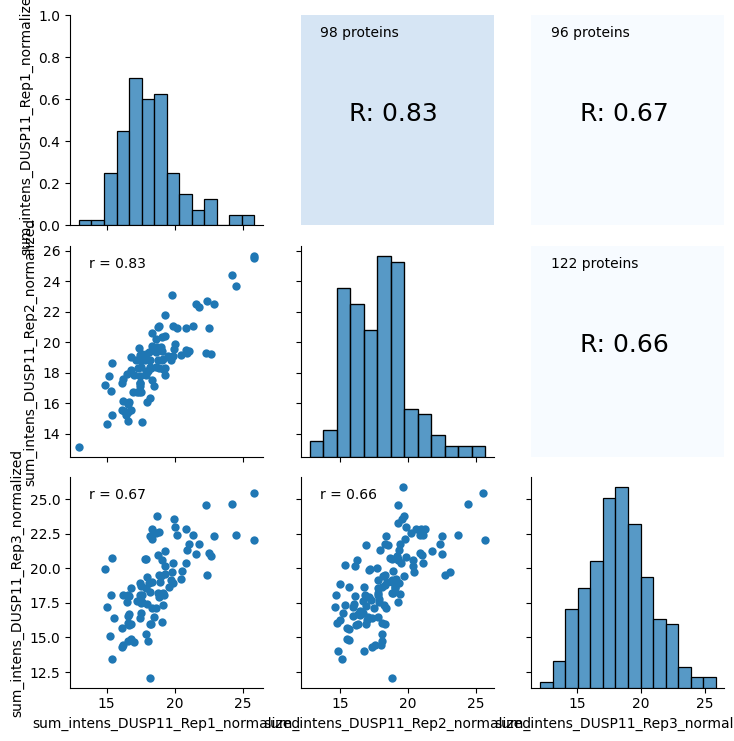

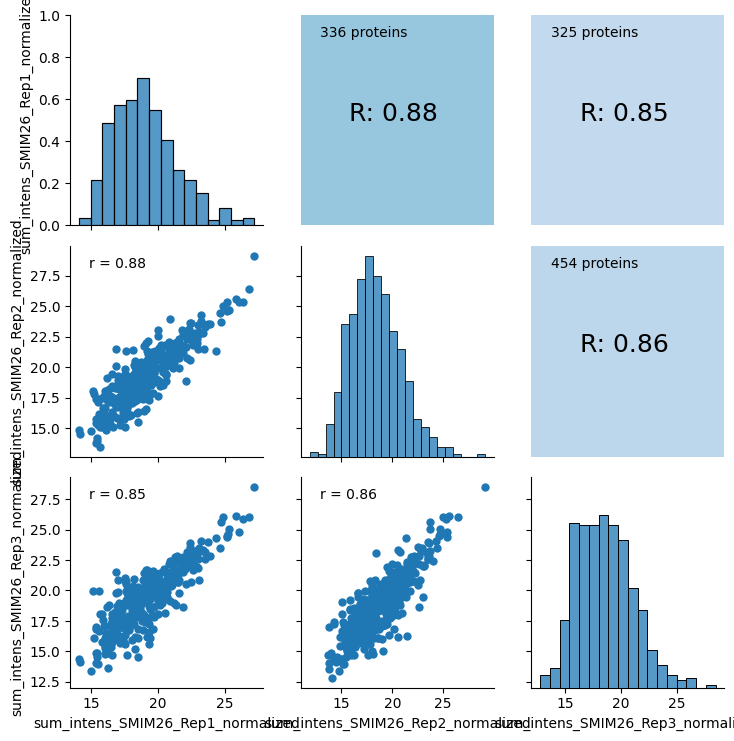

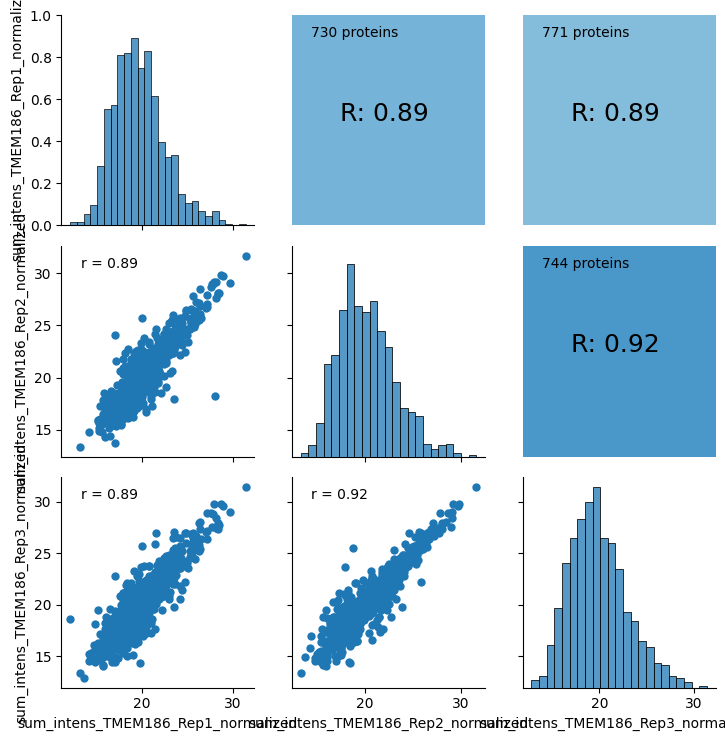

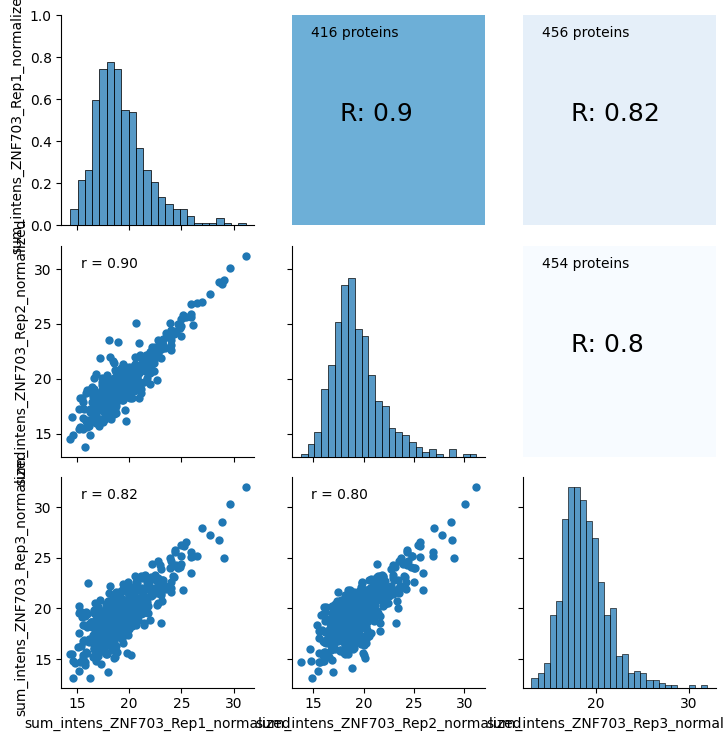

In [10]:
for exp in ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    cols = pg.filter(regex=f"sum_intens_{exp}_Rep\d_normalized").columns.tolist()
    vis.correlogram(pg, cols)
    plt.savefig(f"PR100_correlogram_3reps_{exp}.pdf", dpi=300)

In [11]:
# median imputation if values exist
control_intens_cols = pg.filter(
    regex="sum_intens_Ctrl_Rep\d_normalized"
).columns.tolist()
# print
print(
    f"Row-wise median imputation for {len(pg) - pg[control_intens_cols].isnull().all(1).sum()} values."
)
# row-wise median imputation
pg[control_intens_cols] = pg.loc[
    ~pg[control_intens_cols].isnull().all(1), control_intens_cols
].apply(lambda row: row.fillna(row.median()), axis=1)

Row-wise median imputation for 178 values.


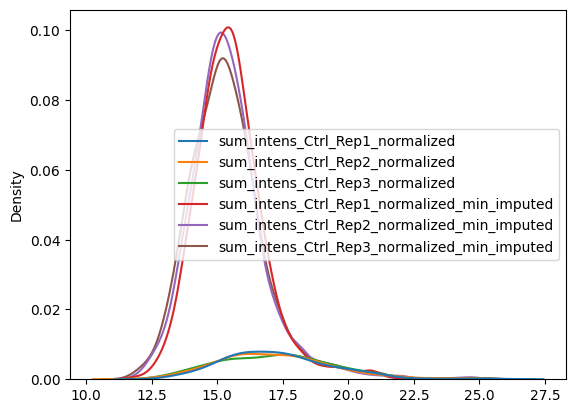

In [12]:
pg = pp.imp_min_prob(pg, cols_to_impute=control_intens_cols, downshift=1, width=0.5)
sns.kdeplot(pg.filter(regex="sum_intens_Ctrl_Rep\d+_normalized"))
plt.savefig(f"PR100_hist_ctrl_impute_3reps.pdf", dpi=300)
plt.show()

In [13]:
for_pca = []
for exp in ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    for rep in range(1, 4):
        # sum all slices per replicate
        for_pca.append(f"sum_intens_{exp}_Rep{rep}_normalized")

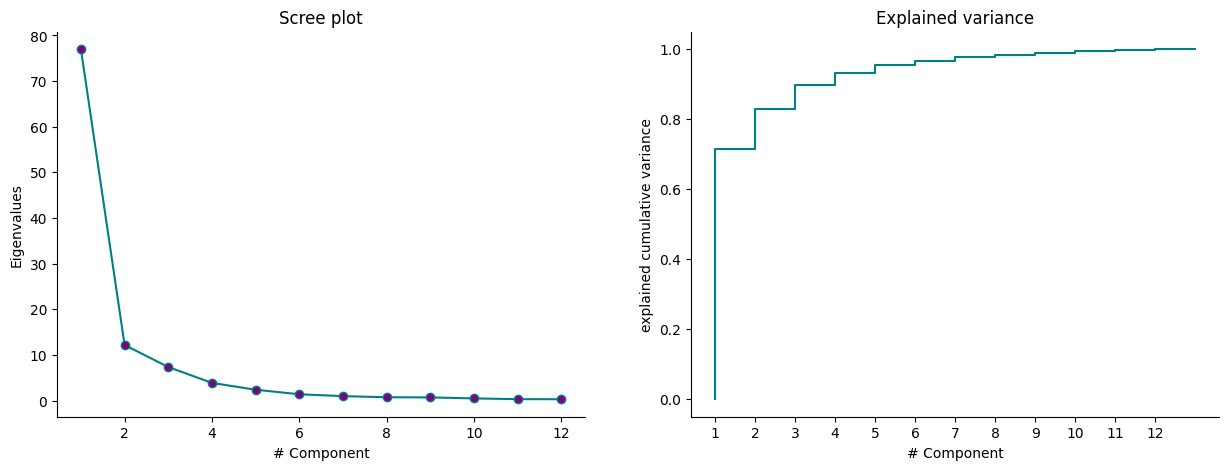

In [14]:
pca = ana.AutoPCA(
    pg[for_pca], clabels=None, batch=[x.split("_")[2] for x in for_pca], rlabels=None
)
pca.scree()
plt.savefig(f"PR100_scree_3reps.pdf", dpi=300)

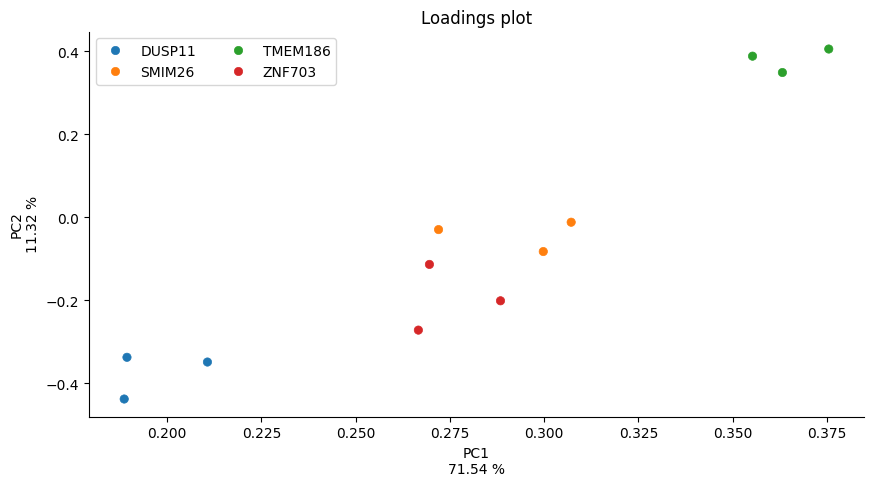

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
pca.loading_plot(pc1=1, pc2=2, labeling=True, ax=ax)
plt.legend(ncol=2)
plt.savefig(f"PR100_loadings_3reps.pdf", dpi=300)
plt.show()

# Statistics

In [16]:
experiments = ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]

for exp in experiments:
    fished = pg.filter(regex=f"sum_intens_{exp}_Rep\d_normalized")
    control = pg.filter(regex="sum_intens_Ctrl_.*_min_imputed")

    # define ratio colnames
    ratio_cols = [f"Ratio_{exp}_Rep{i+1}" for i in range(fished.shape[1])]

    # calculate log2 ratio fished vs. control
    pg[ratio_cols] = fished.values - control.values

    # create temp db with rows with less than 2 vvs removed
    temp = pg.copy()
    temp = pp.filter_vv(temp, [ratio_cols], n=2)

    temp = ana.rank_prod(
        temp,
        reps=ratio_cols,
        cond=f"_ranksum_ratios_{exp}",
    )

    temp = ana.rank_prod(
        temp,
        reps=fished.columns,
        cond=f"_ranksum_intens_{exp}",
    )

    # add the stats cols to the original df
    pg = pd.merge(
        pg,
        temp[ratio_cols + temp.filter(regex="limma|ranksum").columns.tolist()],
        how="left",
    )

1287 rows before filter operation.
164 rows after filter operation.
rankProd: Assuming a one sample test
rankProd: Assuming a one sample test
1287 rows before filter operation.
493 rows after filter operation.
rankProd: Assuming a one sample test
rankProd: Assuming a one sample test
1287 rows before filter operation.
891 rows after filter operation.
rankProd: Assuming a one sample test
rankProd: Assuming a one sample test
1287 rows before filter operation.
562 rows after filter operation.
rankProd: Assuming a one sample test
rankProd: Assuming a one sample test


Not enough data points for KDE. Return original point cloud.


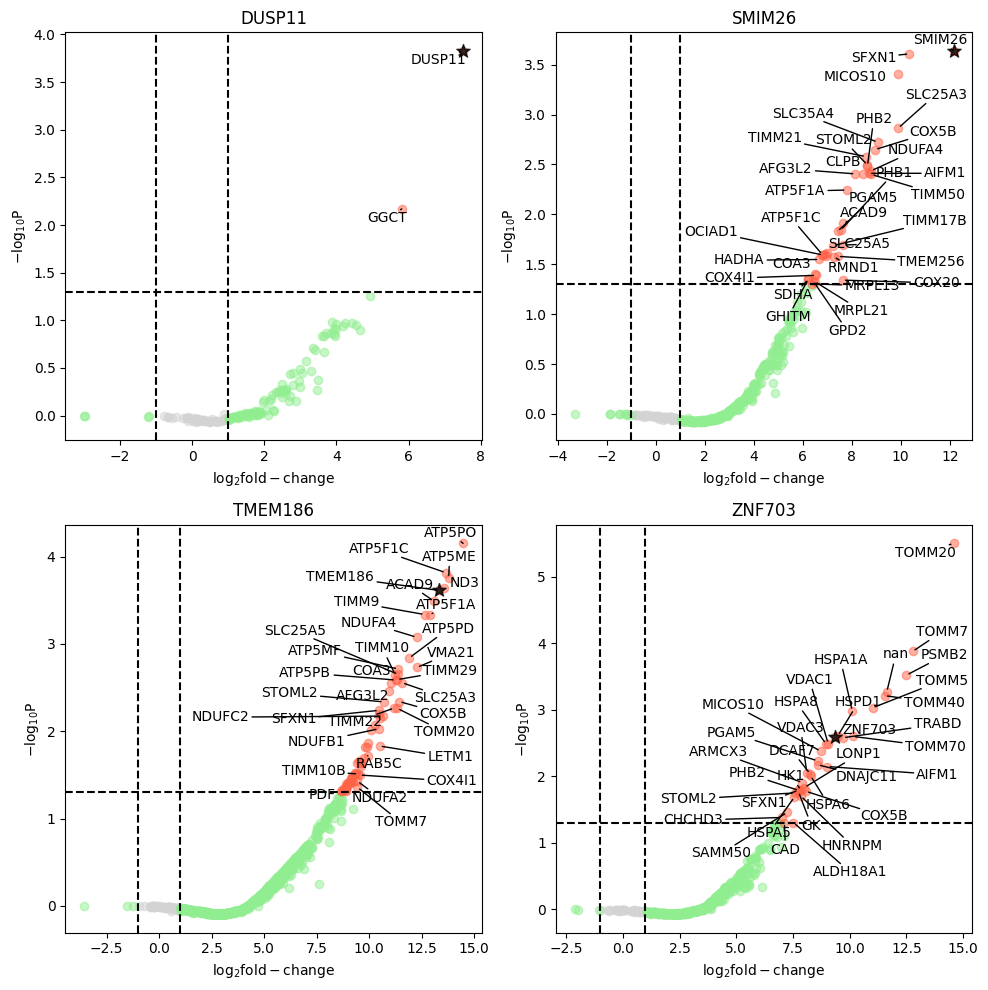

In [17]:
experiments = ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for exp, ax in zip(experiments, axs.flatten()):
    highlight = pg[pg["Gene names first"] == exp].index

    vis.volcano(
        pg,
        highlight=highlight,
        kwargs_highlight={"color": "black", "marker": "*", "s": 100},
        log_fc_colname=f"logFC_ranksum_ratios_{exp}",
        p_colname=f"adj.P.Val_class1>class2_ranksum_ratios_{exp}",
        annotate_colname="Gene names first",
        ax=ax,
        show_caption=False,
        show_legend=False,
        # annotate_density=50,
    )

    ax.set_title(exp)

plt.tight_layout()
plt.savefig(
    "PR100_VolcanoPlot_ranksum_ratio_DUSP11_SMIM26_TMEM186_ZNF703_3reps.pdf", dpi=300
)

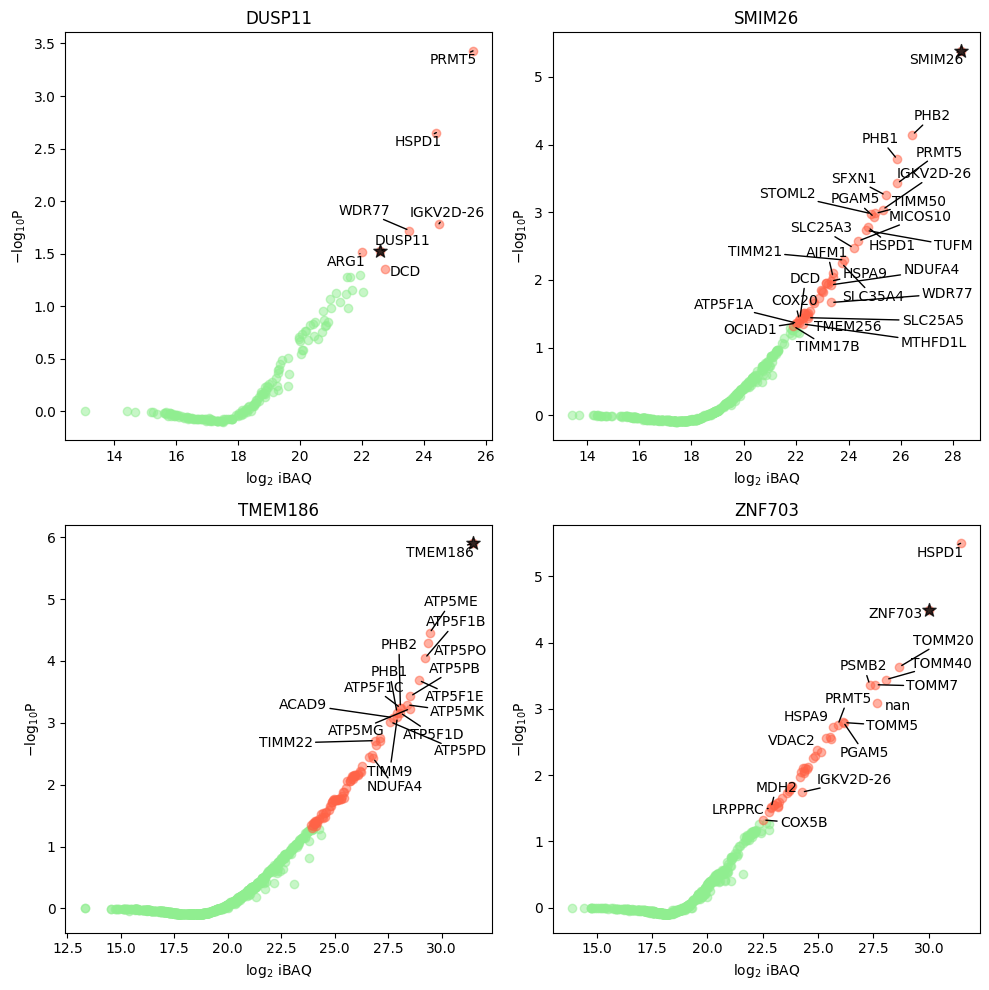

In [18]:
experiments = ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for exp, ax in zip(experiments, axs.flatten()):
    highlight = pg[pg["Gene names first"] == exp].index

    vis.volcano(
        pg,
        highlight=highlight,
        kwargs_highlight={"color": "black", "marker": "*", "s": 100},
        log_fc_colname=f"logFC_ranksum_intens_{exp}",
        p_colname=f"adj.P.Val_class1>class2_ranksum_intens_{exp}",
        annotate_colname="Gene names first",
        ax=ax,
        show_caption=False,
        show_legend=False,
        # annotate_density=50,
        show_thresh=False,
    )

    ax.set_xlabel("log$_2$ iBAQ")
    ax.set_title(exp)

plt.tight_layout()
plt.savefig(
    "PR100_VolcanoPlot_ranksum_itnens_DUSP11_SMIM26_TMEM186_ZNF703_3reps.pdf", dpi=300
)

# Writing results table

#### Statistics results helper columns
To aid the interpretation of the statistics results, we provide columns indicating fold-change, -log10 p-value and the significance status as described in the volcano plots.

In [19]:
experiments = ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]

for test in ["RankSum_Ratios", "RankSum_Intens"]:
    for exp in experiments:
        pg[f"{test} {exp} Fold change"] = pg[f"logFC_{test.lower()}_{exp}"].apply(
            lambda x: 2**x
        )

        pg[f"{test} -log10 p-value_{exp}"] = pg[
            f"adj.P.Val_class1>class2_{test.lower()}_{exp}"
        ].apply(lambda x: -np.log10(x))

        pg[f"{test} significant_{exp}"] = False

        pg.loc[
            (pg[f"logFC_{test.lower()}_{exp}"].abs() > 0)
            & (pg[f"{test} -log10 p-value_{exp}"] > -np.log10(0.05)),
            f"{test} significant_{exp}",
        ] = True

In [20]:
columns_to_delete = [
    # general
    "UID",
    r"^t_limma_(.*)",
    "^CI.L_limma_(.*)",
    "^CI.R_limma_(.*)",
    "^B_limma_",
    "^score_ttest_(.*)",
    "Unique + razor sequence coverage \[%\]",
    "Unique sequence coverage \[%\]",
    "Sequence length.*",
    "Fraction average",
    r"^AveExpr_limma_(.*)",
    r"Fraction \d+",
    "MS/MS IDs",
    "Best MS/MS",
    "Taxonomy IDs",
    "Peptide counts (.*)",
    r"^Peptide sequences$",
    r"Peptide IDs",
    r"Peptide is razor",
    r"Mod. peptide IDs",
    r"Evidence IDs",
    r"^.* site IDs$",
    r"^.* site positions$",
    r"^.*class1<class2.+",
    r"CI.\w+_limma",
    r"AveExpr_limma",
    r"t_limma",
    "B_limma",
]

columns_to_rename = [
    (r"log2_Intensity", r"log2 Intensity"),
    (r"^log2_Ratio ([H|M|L]/[H|M|L].*)", r"log2 Ratio \1"),
    (r"^logFC_limma(.*)", r"LIMMA mean log2 fold-change \1"),
    (r"^P.Value_limma(.*)", r"LIMMA raw p value \1"),
    (r"^adj.P.Val_limma(.*)", r"LIMMA corrected p value \1"),
    (r"adj.P.Val_class1>class2_rankprod(.*)", r"RankProduct corrected p value \1"),
    (r"PValue_class1>class2_rankprod(.*)", r"RankProduct raw p value \1"),
    (r"^logFC_rankprod(.*)", r"RankProduct mean log2 fold-change \1"),
    (r"^pValue_ttest(.*)", r"ttest raw p value \1"),
    (r"^logFC_ttest(.*)", r"ttest log2 fold-change \1"),
    (r"adj.pValue_ttest(.*)", r"ttest corrected p value \1"),
    (r"^id$", "Protein Groups ID"),
    (r"Number of proteins", "Number of proteins in protein group"),
    (r"(.*)_norm(.*)", r"\1 normalized \2"),
    (r"RankSum_Intens (\w+)", r"RankProduct (Intens-based) \1"),
    (r"RankSum_Ratios (\w+)", r"RankProduct (Ratio-based) \1"),
]

cols_order = [
    # General columns
    "Protein Groups ID",
    "Protein IDs",
    "Majority protein IDs",
    "Systematic Name",
    "Protein names",
    "Gene names",
    "Gene names first",
    "Fasta headers",
    "Number of proteins in protein group",
    r"Sequence coverage \[%\]",
    r"Mol. weight \[kDa\]",
    "Q-value",
    "Score",
    "Corrected log2 Ratio .*",
    ".*LIMMA.*",
    ".*RankProd.*",
    "^Sequence coverage .* \[%\]",
    "^Peptides.*",
    "^Unique peptides.*",
    ".*",
]

In [21]:
import xlsxwriter


def write_styled_sheet(writer, sheetname, df):
    df.to_excel(
        writer, sheet_name=sheetname, startrow=1, startcol=0, index=False, header=False
    )

    # Get the xlsxwriter objects from the dataframe writer object.
    workbook = writer.book
    worksheet = writer.sheets[sheetname]

    # Add a header format.
    header_format = workbook.add_format(
        {
            "bold": True,
            "text_wrap": True,
            "valign": "vcenter",
            "fg_color": "#EAEAEA",
            "border": False,
            "align": "center",
            "bottom": 5,
        }
    )

    # Write the column headers with the defined format.
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    worksheet.autofilter(0, 0, df.shape[0], df.shape[1])
    worksheet.freeze_panes(1, 0)

In [22]:
import re

# Creating Excel Writer Object from Pandas
results_writer = pd.ExcelWriter(
    f"PR100_table.xlsx",
    engine="xlsxwriter",
)

# merge the original proteinGroups.txt to include all measured data
filtered_rows = list(set(pg_raw["id"]).difference(set(pg["id"])))
tmp = pd.concat([pg, pg_raw[pg_raw["id"].isin(filtered_rows)]])
tmp.sort_values(by="id", inplace=True)

for regex in columns_to_delete:
    print(f"Deleting {regex}")
    tmp.drop(tmp.filter(regex=regex).columns, axis=1, inplace=True)

for regex in columns_to_rename:
    print(f"Replacing {regex[0]}")
    tmp = tmp.rename(columns=lambda x: re.sub(regex[0], regex[1], x))

# reorder columns
old_cols = tmp.columns
new_cols = []
for regex in cols_order:
    r = re.compile(regex)
    new_cols.extend([i for i in old_cols if r.match(i)])
    old_cols = [x for x in old_cols if x not in new_cols]

tmp = tmp[new_cols]

write_styled_sheet(results_writer, "PR100", tmp)

# Close the Pandas Excel writer and output the Excel file.
results_writer.close()

Deleting UID
Deleting ^t_limma_(.*)
Deleting ^CI.L_limma_(.*)
Deleting ^CI.R_limma_(.*)
Deleting ^B_limma_
Deleting ^score_ttest_(.*)
Deleting Unique + razor sequence coverage \[%\]
Deleting Unique sequence coverage \[%\]
Deleting Sequence length.*
Deleting Fraction average
Deleting ^AveExpr_limma_(.*)
Deleting Fraction \d+
Deleting MS/MS IDs
Deleting Best MS/MS
Deleting Taxonomy IDs
Deleting Peptide counts (.*)
Deleting ^Peptide sequences$
Deleting Peptide IDs
Deleting Peptide is razor
Deleting Mod. peptide IDs
Deleting Evidence IDs
Deleting ^.* site IDs$
Deleting ^.* site positions$
Deleting ^.*class1<class2.+
Deleting CI.\w+_limma
Deleting AveExpr_limma
Deleting t_limma
Deleting B_limma
Replacing log2_Intensity
Replacing ^log2_Ratio ([H|M|L]/[H|M|L].*)
Replacing ^logFC_limma(.*)
Replacing ^P.Value_limma(.*)
Replacing ^adj.P.Val_limma(.*)
Replacing adj.P.Val_class1>class2_rankprod(.*)
Replacing PValue_class1>class2_rankprod(.*)
Replacing ^logFC_rankprod(.*)
Replacing ^pValue_ttest(.*